In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import idx2numpy

In [2]:
f=open("train-images.idx3-ubyte","rb")
X_train=idx2numpy.convert_from_file(f)
f.close()
f=open("train-labels.idx1-ubyte","rb")
y_train=idx2numpy.convert_from_file(f)
f.close()
f=open("t10k-images.idx3-ubyte","rb")
X_test=idx2numpy.convert_from_file(f)
f.close()
f=open("t10k-labels.idx1-ubyte","rb")
y_test=idx2numpy.convert_from_file(f)
f.close()

In [3]:
print("Training data",X_train.shape)
print("Training labels",y_train.shape)
print("Testing data",X_test.shape)
print("Training labels",y_test.shape)

Training data (60000, 28, 28)
Training labels (60000,)
Testing data (10000, 28, 28)
Training labels (10000,)


In [4]:
print(np.unique(y_train))

[0 1 2 3 4 5 6 7 8 9]


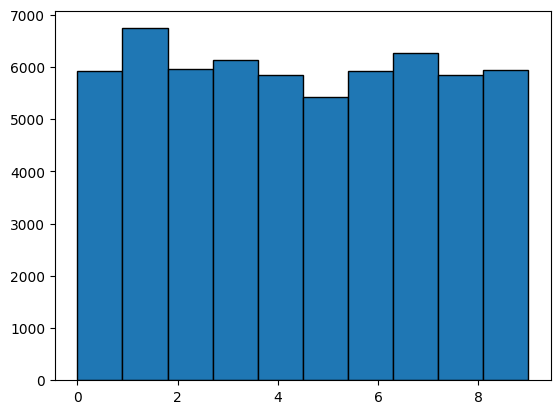

In [5]:
plt.hist(y_train,edgecolor="black")
plt.show()


In [6]:
X_val=X_train[48000:]
y_val=y_train[48000:]
X_train=X_train[:48000]
y_train=y_train[:48000]

In [7]:
X_train=X_train/255.0
X_val=X_val/255.0
X_test=X_test/255.0

In [8]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(48000, 28, 28)
(12000, 28, 28)
(10000, 28, 28)


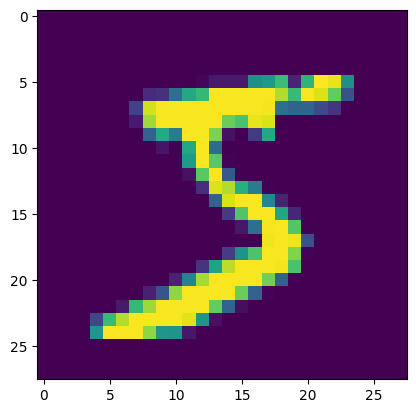

5


In [9]:
plt.imshow(X_train[0])
plt.show()
print(y_train[0])

In [10]:
X_train=X_train.reshape((48000,28*28))
X_val=X_val.reshape((12000,28*28))
X_test=X_test.reshape((10000,28*28))             

In [11]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(48000, 784)
(12000, 784)
(10000, 784)


In [14]:
class NeuralNetwork:
    def __init__(self,num_layers,layer_sizes,learning_rate,weight_init_fn,activation_fn,epochs,batch_size):
        self.num_layers=num_layers
        self.layer_sizes=layer_sizes
        self.learning_rate=learning_rate

        if(activation_fn.lower()!="ReLu".lower() and activation_fn.lower()!="sigmoid".lower() and activation_fn.lower()!="tanh".lower() and activation_fn.lower()!="Leaky ReLu".lower() and activation_fn.lower()!="softmax".lower()):
            raise ValueError("Specify a valid activation function.")
        else:
            self.activation_fn=activation_fn
        
        if(weight_init_fn.lower()!="Zero Init".lower() and weight_init_fn.lower()!="Random Init".lower() and weight_init_fn.lower()!="Normal Init".lower()):
            raise ValueError("Specify a valid weight initialization function")
        else:
            self.weight_init_fn=weight_init_fn

        if(epochs<=0):
            raise ValueError("Number of epochs has to be positive.")
        else:
            self.epochs=epochs
        self.batch_size=batch_size
        self.biases=None
        self.weights=None
        self.activations=None
        self.training_losses=[]
        self.training_batch_losses=[]
        self.training_batch_accuracies=[]
        self.validation_losses=[]
        self.training_accuracies=[]
        self.validation_accuracies=[]


    def initialize_params(self,x_train,y_train):
        input_neurons=x_train.shape[1]
        # print(input_neurons)
        output_neurons=len(np.unique(y_train))
        if(self.weight_init_fn.lower()=="zero init"):
            self.zero_init(input_neurons,output_neurons)
        elif(self.weight_init_fn.lower()=="random init"):
            self.random_init(input_neurons,output_neurons)
        else:
            self.normal_init(input_neurons,output_neurons)

    def zero_init(self, input_neurons,output_neurons):
        self.weights={} #list
        self.biases={}  #list of numpy arrays
        arr=np.zeros((input_neurons,self.layer_sizes[0]))
        # print(arr.shape)
        self.weights[1]=arr
        for i in range(self.num_layers-1):
            arr=np.zeros((self.layer_sizes[i],self.layer_sizes[i+1]))
            self.weights[i+2]=arr
            self.biases[i+1]=np.zeros((self.layer_sizes[i]))
        arr=np.zeros((self.layer_sizes[-1],output_neurons))
        self.weights[self.num_layers+1]=arr
        self.biases[self.num_layers]=np.zeros((self.layer_sizes[-1]))
        self.biases[self.num_layers+1]=np.zeros((output_neurons))

    def random_init(self, input_neurons,output_neurons):
        self.weights={} #list
        self.biases={}  #list of numpy arrays
        arr=np.random.rand(input_neurons,self.layer_sizes[0])
        # print(arr.shape)
        self.weights[1]=arr
        for i in range(self.num_layers-1):
            arr=np.random.rand(self.layer_sizes[i],self.layer_sizes[i+1])
            self.weights[i+2]=arr
            self.biases[i+1]=np.random.rand(self.layer_sizes[i])
        arr=np.random.rand(self.layer_sizes[-1],output_neurons)
        self.weights[self.num_layers+1]=arr
        self.biases[self.num_layers]=np.random.rand(self.layer_sizes[-1])
        self.biases[self.num_layers+1]=np.random.rand(output_neurons)

    def normal_init(self, input_neurons,output_neurons):
        self.weights={} #list
        self.biases={}  #list of numpy arrays
        arr=np.random.normal(0,1,size=(input_neurons,self.layer_sizes[0]))
        # print(arr.shape)
        self.weights[1]=arr
        for i in range(self.num_layers-1):
            arr=np.random.normal(0,1,size=(self.layer_sizes[i],self.layer_sizes[i+1]))
            self.weights[i+2]=arr
            self.biases[i+1]=np.random.normal(0,1,size=(self.layer_sizes[i]))
        arr=np.random.normal(0,1,size=(self.layer_sizes[-1],output_neurons))
        self.weights[self.num_layers+1]=arr
        self.biases[self.num_layers]=np.random.normal(0,1,size=(self.layer_sizes[-1]))
        self.biases[self.num_layers+1]=np.random.normal(0,1,size=(output_neurons))


    def sigmoid(self,X):
        X=X.astype(np.float64)
        return ((1/(1+np.exp(-X))))
    
    def tanh(self,X):
        return np.tanh(X)
    
    def relu(self,X):
        return np.maximum(0,X)
    
    def leaky_relu(self,X,alpha=0.01):
        return np.maximum(alpha*X,X)
    
    def softmax(self,X):
        return np.exp(X)/(np.sum(np.exp(X),axis=0))

    def acivation(self,x):
        if(self.activation_fn.lower()=="leaky relu"):
            return self.leaky_relu(x) 
        elif(self.activation_fn.lower()=="sigmoid"):
            return self.sigmoid(x)
        elif(self.activation_fn.lower()=="tanh"):
            return self.tanh(x)
        elif(self.activation_fn.lower()=="relu"):
            return self.relu(x)
        else: 
            raise ValueError("Invalid activation function")

    def forward(self, sample):
        z_outputs={}
        a_outputs={}
        res=sample
        for i in range(len(self.weights)):
            # print("Multiplying with layer",i+1)
            # print(self.weights[i+1].T.shape)
            # print(res.shape)
            # print((self.weights[i+1].T@res).shape)
            res=self.weights[i+1].T@res+self.biases[i+1]
            z_outputs[i+1]=np.atleast_2d(res).T
            if(i+1!=len(self.weights)):
                # print("Activating on layer",i+1, self.weights[i+1])
                # print(self.activation_fn)
                res=self.acivation(res)
                a_outputs[i+1]=np.atleast_2d(res).T

        output=self.softmax(res)
        a_outputs[self.num_layers+1]=np.atleast_2d(output).T
        return z_outputs, a_outputs, output
    
    
    def relu_derivative(self,X):
        return (X>0)*1 
    
    def sigmoid_derivative(self,X):
        return self.sigmoid(X)*(1-self.sigmoid(X))
    
    def tanh_derivative(self,x):
        return 1-np.power((np.tanh(x)),2)
    
    def leaky_relu_derivative(self,X, alpha=0.01):
        return np.where(X>0,1,alpha)
    
    def acivation_derivative(self,x):
        if(self.activation_fn.lower()=="leaky relu"):
            return self.leaky_relu_derivative(x) 
        elif(self.activation_fn.lower()=="sigmoid"):
            return self.sigmoid_derivative(x)
        elif(self.activation_fn.lower()=="tanh"):
            return self.tanh_derivative(x)
        elif(self.activation_fn.lower()=="relu"):
            return self.relu_derivative(x)
        else: 
            raise ValueError("Invalid activation function")

    def one_hot_encode(self, y_predicted, y_true):
        mat=np.zeros(y_predicted.shape)
        mat[y_true]=1
        return mat

    def compute_gradients(self, sample, sample_activated_outputs, sample_unactivated_output, y_predicted, y_train,):
        unactivated_gradients_W={i:None for i in self.weights.keys()}
        unactivated_gradients_Wtr={i:None for i in self.weights.keys()}
        activated_gradients_W={i:None for i in self.weights.keys()}
        # db={i:None for i in self.biases.keys()}
        # dW={i:None for i in self.weights.keys()}
        y_true=self.one_hot_encode(y_predicted,y_train)

        residual=y_true-y_predicted

        #we will proceed layer by layer BACKWARD 
        number_of_layers=self.num_layers+1 #output layer added

        residual=np.atleast_2d(residual).T
        unactivated_gradients_W[number_of_layers]=residual
        unactivated_gradients_Wtr[number_of_layers]=residual.T

        # print(unactivated_gradients_W)
        # print(unactivated_gradients_Wtr)

        """   
        first hidden layer=1
        second hidden layer=2
        ...
        ...
        output layer= num_layers+1 because num_layers is number of hidden layers
        """
        sample=np.atleast_2d(sample).T
        # print("sample",sample.shape)
        for i in range(number_of_layers,0,-1):
            # print(i)
            if(i==1):
                unactivated_gradients_W[i]=np.multiply(self.weights[i+1]@unactivated_gradients_W[i+1],(self.acivation_derivative(sample_activated_outputs[i])))
                unactivated_gradients_Wtr[i]=unactivated_gradients_W[i].T
                # print(sample_activated_outputs[i-1].shape, unactivated_gradients_W[i].shape)
                activated_gradients_W[i]=sample@unactivated_gradients_Wtr[i]
            elif(i==number_of_layers):
                # print(sample_activated_outputs[i-1].shape, unactivated_gradients_W[i].shape)
                activated_gradients_W[i]=sample_activated_outputs[i-1]@unactivated_gradients_Wtr[i]
            else:
                # print(i, self.weights[i+1].shape, unactivated_gradients_W[i+1].shape)
                # print("Sample activated [i] ",(sample_activated_outputs[i]).shape)
                unactivated_gradients_W[i]=np.multiply(self.weights[i+1]@unactivated_gradients_W[i+1],(self.acivation_derivative(sample_activated_outputs[i])))
                unactivated_gradients_Wtr[i]=unactivated_gradients_W[i].T
                # print(sample_activated_outputs[i-1].shape, unactivated_gradients_W[i].shape)
                activated_gradients_W[i]=sample_activated_outputs[i-1]@unactivated_gradients_Wtr[i]

        for i in unactivated_gradients_W.keys():
            unactivated_gradients_W[i]=unactivated_gradients_W[i].flatten()

        return activated_gradients_W,unactivated_gradients_W


    def backward(self, y_pred, y_train, net_dW, net_dB):
        raise NotImplementedError

    def compute_loss(self, y_pred, y_train):
        y_true=self.one_hot_encode(y_pred,y_train)
        return -np.dot(y_true,np.log(y_pred))

    
    def fit(self, X_train,y_train,X_val=None,y_val=None):
        self.initialize_params(X_train,y_train)


        for epoch in range(self.epochs):
            #split into a batch

            #shuffle the data
            p = np.random.permutation(len(X_train))
            X_train=X_train[p]
            y_train=y_train[p]
            

            for batch in range(0,X_train.shape[0],self.batch_size):
                
                if(batch+self.batch_size>=X_train.shape[0]):
                    X=X_train[batch:]
                    Y=y_train[batch:]
                else:
                    X=X_train[batch:batch+self.batch_size]
                    Y=y_train[batch:batch+self.batch_size]

                dW_net=None
                db_net=None
                train_loss=0
                # val_loss=0

                for i in range(len(X)):
                    z_pred,a_pred,y_pred=self.forward(X[i])
                    y_true=Y[i]
                    train_loss+=self.compute_loss(y_pred,y_true)
                    dW,db=self.compute_gradients(X[i],a_pred,z_pred,y_pred,y_true)
                    if(dW_net is not None and db_net is not None):
                        for key in dW.keys():
                            dW_net[key]+=dW[key]
                            db_net[key]+=db[key]
                    else:
                        dW_net=dW
                        db_net=db 
                

                self.training_batch_losses.append(train_loss/self.batch_size)
                self.training_batch_accuracies.append(self.score(X,Y))
                
                
                # print(f"Batch: {batch/self.batch_size}, Train loss: {train_loss/len(X)}")


                #backward update
                for i in self.weights.keys():
                    self.weights[i]+=self.learning_rate*dW_net[i]
                    self.biases[i]+=self.learning_rate*db_net[i]

            self.training_losses.append(self.compute_batch_loss(X_train,y_train))
            self.training_accuracies.append(self.score(X_train,y_train))
            if(X_val is not None and y_val is not None):
                    self.validation_losses.append(self.compute_batch_loss(X_val, y_val))
                    self.validation_accuracies.append(self.score(X_val,y_val))
            print(f"Epoch: {epoch}, training loss: {self.compute_batch_loss(X_train,y_train)}, val loss: {self.compute_batch_loss(X_val, y_val)}")

    
    def prediction(self,X):
        return np.argmax(self.forward(X)[2],axis=0)
    
    def predict_proba(self,X):
        return self.forward(X)[2]
    
    def score(self,X,Y):
        #here X is the whole dataset 
        count=0
        for i in range(len(X)):
            if(self.prediction(X[i])==Y[i]):
                count+=1 
        return count/len(X)
    
    def compute_batch_loss(self,X,Y):
        loss=0
        for i in range(len(X)):
            loss+=self.compute_loss((self.forward(X[i])[2]),Y[i])

        return loss/len(X)


    def plot_batchwise_loss_curve(self):
        plt.plot(self.training_batch_losses)
        # plt.plot(self.validation_losses,color="orange")
        plt.legend()
        plt.xlabel("Batch")
        plt.ylabel("Loss")
        plt.title("Loss vs batch")
        plt.show()

    def plot_train_val_loss(self):
        plt.plot(self.training_losses)
        plt.plot(self.validation_losses)
        plt.legend()
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Loss vs epoch")
        plt.show()



In [20]:
model=NeuralNetwork(4,[256,128,64,32],learning_rate=2e-4,weight_init_fn="normal init",activation_fn="sigmoid",epochs=50,batch_size=128)
model.fit(X_train,y_train, X_val,y_val)

Epoch: 0, training loss: 1.1386323820802162, val loss: 1.112804596771594
Epoch: 1, training loss: 0.8362979542001953, val loss: 0.7991840198700833
Epoch: 2, training loss: 0.7224356866930834, val loss: 0.6761115497923624
Epoch: 3, training loss: 0.6564739448365667, val loss: 0.6150305763915396
Epoch: 4, training loss: 0.6083668049192774, val loss: 0.5714434852383146
Epoch: 5, training loss: 0.5763276841805403, val loss: 0.5458735768164579


C:\Users\user\AppData\Local\Temp\ipykernel_11908\353709328.py:92: RuntimeWarning: overflow encountered in exp
  return ((1/(1+np.exp(-X))))


Epoch: 6, training loss: 0.5575473482671158, val loss: 0.5281688809454583
Epoch: 7, training loss: 0.5402884245023447, val loss: 0.5147751139717156
Epoch: 8, training loss: 0.5237755243912064, val loss: 0.5044578428921072
Epoch: 9, training loss: 0.5130232363531724, val loss: 0.49108804200498346
Epoch: 10, training loss: 0.5036294575410983, val loss: 0.4772054069699684
Epoch: 11, training loss: 0.4935209499778267, val loss: 0.46803428029947425
Epoch: 12, training loss: 0.4866846499272296, val loss: 0.46351386017752
Epoch: 13, training loss: 0.48260733726977467, val loss: 0.4584742149058884
Epoch: 14, training loss: 0.4790490956289024, val loss: 0.45524020697076134
Epoch: 15, training loss: 0.47411320905296467, val loss: 0.44357832912132744
Epoch: 16, training loss: 0.4718472453461305, val loss: 0.43891206694279794
Epoch: 17, training loss: 0.4676909145803682, val loss: 0.43323933335905984
Epoch: 18, training loss: 0.4627296339298274, val loss: 0.42848192149581865
Epoch: 19, training lo

C:\Users\user\AppData\Local\Temp\ipykernel_11908\353709328.py:316: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


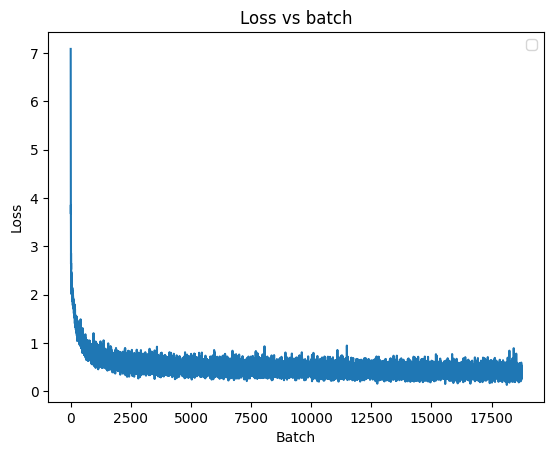

In [21]:
model.plot_batchwise_loss_curve()

C:\Users\user\AppData\Local\Temp\ipykernel_11908\353709328.py:325: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


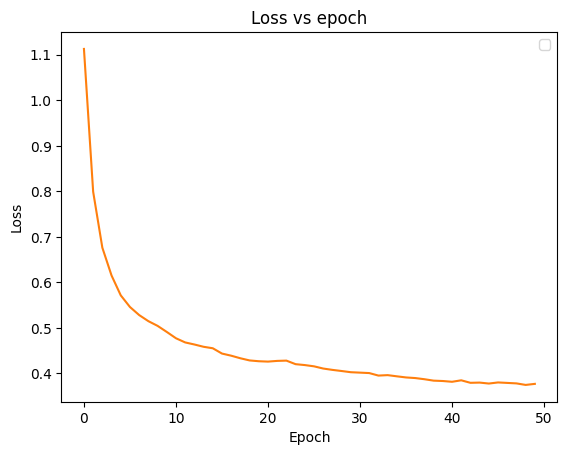

In [22]:
model.plot_train_val_loss()

In [23]:
print(f"Training accuracy: {model.score(X_train, y_train)}, Training loss: {model.compute_batch_loss(X_train,y_train)}")
print(f"Val accuracy: {model.score(X_val, y_val)}, Val loss: {model.compute_batch_loss(X_val,y_val)}")

C:\Users\user\AppData\Local\Temp\ipykernel_11908\353709328.py:92: RuntimeWarning: overflow encountered in exp
  return ((1/(1+np.exp(-X))))


Training accuracy: 0.88675, Training loss: 0.39191056827552145
Val accuracy: 0.8901666666666667, Val loss: 0.3770189730150357


In [24]:
print(f"Testing accuracy: {model.score(X_test,y_test)}, Test Loss: {model.compute_batch_loss(X_test,y_test)}")


C:\Users\user\AppData\Local\Temp\ipykernel_11908\353709328.py:92: RuntimeWarning: overflow encountered in exp
  return ((1/(1+np.exp(-X))))


Testing accuracy: 0.8929, Test Loss: 0.3825558680553295


[1.1386323820802162,
 0.640125,
 0.8362979542001953,
 0.7486041666666666,
 0.7224356866930834,
 0.7822916666666667,
 0.6564739448365667,
 0.8036666666666666,
 0.6083668049192774,
 0.8196458333333333,
 0.5763276841805403,
 0.8323541666666666,
 0.5575473482671158,
 0.8373125,
 0.5402884245023447,
 0.8417708333333334,
 0.5237755243912064,
 0.8476666666666667,
 0.5130232363531724,
 0.8505208333333333,
 0.5036294575410983,
 0.8540625,
 0.4935209499778267,
 0.8575833333333334,
 0.4866846499272296,
 0.8601041666666667,
 0.48260733726977467,
 0.862125,
 0.4790490956289024,
 0.8625,
 0.47411320905296467,
 0.8644583333333333,
 0.4718472453461305,
 0.8645,
 0.4676909145803682,
 0.8652083333333334,
 0.4627296339298274,
 0.8674166666666666,
 0.4595075730926558,
 0.8692916666666667,
 0.4550234572440448,
 0.8709791666666666,
 0.4549555481577815,
 0.8706666666666667,
 0.45162197664756126,
 0.871125,
 0.44564579632457807,
 0.8723958333333334,
 0.44146082368116574,
 0.8734375,
 0.43848917270447174,
 0.8

#### Debugging space

In [610]:
# nn.forward(X_train[0])
# np.sum(nn.forward(X_train[0])[2])
z,a,out=model.forward(X_train[0])


C:\Users\user\AppData\Local\Temp\ipykernel_33240\984726451.py:89: RuntimeWarning: overflow encountered in exp
  return (1/(1+np.exp(-X)))


In [611]:
out

array([1.48074001e-003, 9.98519260e-001, 1.73217489e-020, 2.47856771e-284,
       1.74536800e-018, 2.65254205e-030, 2.27195076e-012, 1.37121601e-016,
       9.96470240e-020, 2.36129709e-017])

In [612]:
np.sum(out)

1.0

In [591]:
x=np.array([1,2,3])
x=np.atleast_2d(x)
x.T
1/(1+np.exp(-x)).T


array([[0.73105858],
       [0.88079708],
       [0.95257413]])

In [592]:
X_train[0].shape

(784,)

In [593]:
model.weights[1].shape

(784, 3)

In [607]:
z

{1: array([[ -5447.38596992],
        [  2206.91632659],
        [  4472.35170313],
        [ -7967.04349572],
        [-13225.79887357],
        [  5499.01795199],
        [ -7258.62474111],
        [  2036.94656527],
        [ -8419.71917234],
        [  2887.89257235],
        [  1280.11084301],
        [ -3700.9015644 ],
        [  8296.79017069],
        [-16667.84931876],
        [  4016.09674103],
        [  9072.78810937],
        [  -733.14985555],
        [  5513.45086824],
        [  6455.67131666],
        [ 15979.13164859],
        [ 10731.00802085],
        [ 15818.62143415],
        [  6062.44786667],
        [  1252.59228874],
        [ -8171.10305938],
        [  1742.15378227],
        [   778.55820141],
        [  1689.89404056],
        [   688.11837585],
        [ -8338.94079485],
        [  2141.87585917],
        [ -6708.46179682],
        [  2737.33067622],
        [ 12355.19514253],
        [  1753.58497713],
        [ -2562.08377442],
        [ -3820.8467416 ]

In [613]:
for i in a.keys():
    print(i, a[i].shape)

a

1 (256, 1)
2 (128, 1)
3 (64, 1)
4 (32, 1)
5 (10, 1)


{1: array([[0.00000000e+000],
        [1.00000000e+000],
        [1.00000000e+000],
        [0.00000000e+000],
        [0.00000000e+000],
        [1.00000000e+000],
        [0.00000000e+000],
        [1.00000000e+000],
        [0.00000000e+000],
        [1.00000000e+000],
        [1.00000000e+000],
        [0.00000000e+000],
        [1.00000000e+000],
        [0.00000000e+000],
        [1.00000000e+000],
        [1.00000000e+000],
        [0.00000000e+000],
        [1.00000000e+000],
        [1.00000000e+000],
        [1.00000000e+000],
        [1.00000000e+000],
        [1.00000000e+000],
        [1.00000000e+000],
        [1.00000000e+000],
        [0.00000000e+000],
        [1.00000000e+000],
        [1.00000000e+000],
        [1.00000000e+000],
        [1.00000000e+000],
        [0.00000000e+000],
        [1.00000000e+000],
        [0.00000000e+000],
        [1.00000000e+000],
        [1.00000000e+000],
        [1.00000000e+000],
        [0.00000000e+000],
        [0.00000000e+000]

In [596]:
x=np.array([1,2,3])
x=np.atleast_2d(x)
y=np.array([1,2,3])
y=np.atleast_2d(y)
z=np.multiply(x,y)

In [597]:
test_arr=np.array([[2],[1]])
test_arr.shape
1/(1+np.exp(-test_arr))

array([[0.88079708],
       [0.73105858]])

In [598]:
dW,db=(model.compute_gradients(X_train[0],a,z,out,y_train[0]))

In [599]:
for i in model.weights.keys():
    print(model.weights[i].shape, dW[i].shape)
    # print(model.weights[i]-dW[i])
    print(model.biases[i].shape, db[i].shape)



(784, 3) (784, 3)
(3,) (3,)
(3, 2) (3, 2)
(2,) (2,)
(2, 10) (2, 10)
(10,) (10,)
